In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from PIL import Image
from tqdm import tqdm

warnings.filterwarnings("ignore")


# PASO 2: CONFIGURACIONES GENERALES


In [2]:
DATA_PATH = "trash_images"  # CAMBIO: antes usabas "trash_images"
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)  # CAMBIO: tamaño óptimo para ResNet (antes 180x180)
VALIDATION_SPLIT = 0.15
SEED = 133
EPOCHS = 50

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Versión de PyTorch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Versión de PyTorch: 2.9.0+cu130
CUDA: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


# PASO 3: EXPLORACIÓN Y PREPARACIÓN DEL DATASET

In [4]:
main_folder_path = Path(DATA_PATH)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != DATA_PATH:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
cardboard,420
glass,575
metal,474
paper,709
plastic,732
trash,153


In [5]:
# funcion para mostrar las 5 primeras imagenes de cada clase
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
        plt.title(os.path.basename(item_dir)) 

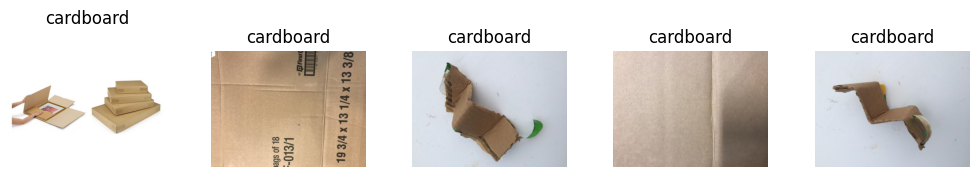

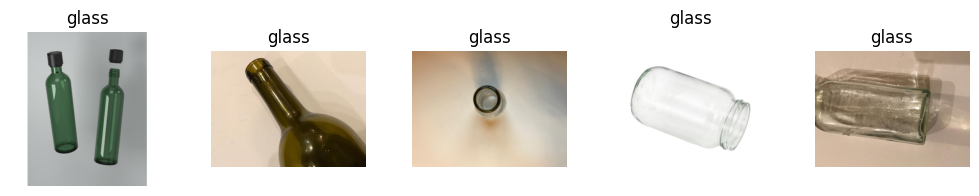

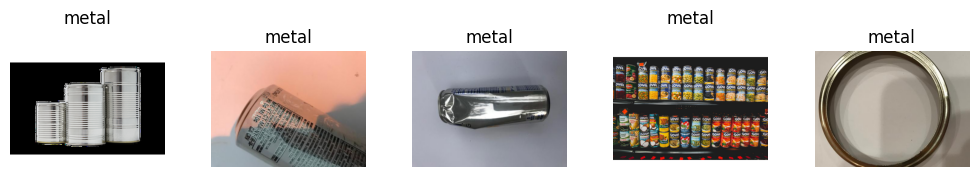

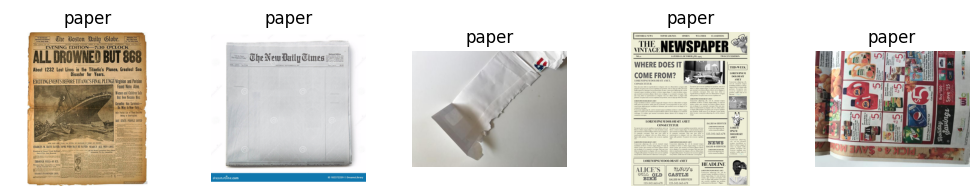

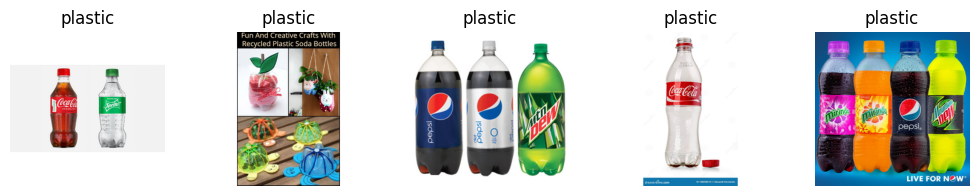

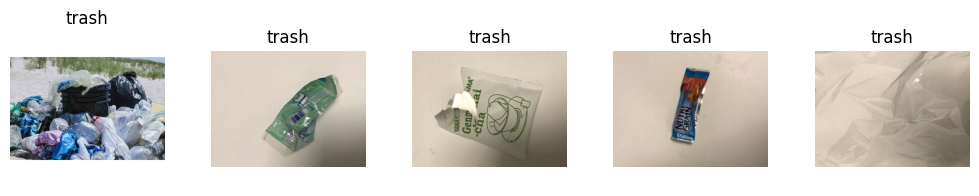

In [ ]:
# muestra de imagenes por clase
plot_imgs(DATA_PATH+'/cardboard')
plot_imgs(DATA_PATH+'/glass')
plot_imgs(DATA_PATH+'/metal')
plot_imgs(DATA_PATH+'/paper')
plot_imgs(DATA_PATH+'/plastic')
plot_imgs(DATA_PATH+'/trash')

# PASO 4: TRANSFORMACIONES DE IMAGEN

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),      # CAMBIO: antes 40°
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),           # CAMBIO: antes 0.3
        scale=(0.9, 1.1),
        shear=5                         # CAMBIO: antes 25
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

val_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

In [8]:
# Dataset principal
full_dataset = datasets.ImageFolder(root=DATA_PATH)
labels = [label for _, label in full_dataset.samples]

print("Clases detectadas:", full_dataset.classes)

Clases detectadas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# PASO 5: SPLIT ESTRATIFICADO TRAIN / VALIDATION

In [9]:
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=VALIDATION_SPLIT,
    random_state=SEED
)

train_idx, val_idx = next(sss.split(np.arange(len(labels)), labels))

train_dataset = Subset(
    datasets.ImageFolder(DATA_PATH, transform=train_transforms),
    train_idx
)
val_dataset = Subset(
    datasets.ImageFolder(DATA_PATH, transform=val_transforms),
    val_idx
)

num_workers = 2 if torch.cuda.is_available() else 0
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=num_workers,
                          pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=num_workers,
                         pin_memory=pin_memory)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}")


Train: 2603, Validation: 460


# PASO 6: CONSTRUCCIÓN DEL MODELO RESNET50

In [10]:
# === BALANCEO DE CLASES ===
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print("Pesos por clase:", weights_tensor)

Pesos por clase: tensor([1.2155, 0.8878, 1.0770, 0.7200, 0.6974, 3.3366], device='cuda:0')


In [11]:
# === MODELO RESNET50 ===
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

num_classes = len(full_dataset.classes)
num_features = model.fc.in_features

# CAMBIO: drop-out añadido para mejorar generalización
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, num_classes)
)

In [ ]:
# Descongelar el layer completo de ResNet50

In [ ]:
# Descongelar desde layer2 para un mejor ajuste (fine-tuning real)
for name, param in model.named_parameters():
    if name.startswith(("layer2", "layer3", "layer4", "fc")):
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(DEVICE)

# PASO 7: CONFIGURACIÓN DE OPTIMIZADOR Y SCHEDULER

In [13]:
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# CAMBIO: AdamW es más estable que Adam clásico
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=5,
    factor=0.1,
    min_lr=1e-5
)

# PASO 8: ENTRENAMIENTO DEL MODELO (EARLY STOPPING)

In [14]:
## Early Stopping
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = "trash_resnet50_best_v3.pth"   # CAMBIO: nuevo nombre versión 3

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [15]:
# === ENTRENAMIENTO ===
from torch import device


for epoch in range(1, EPOCHS + 1):
    print(f"\n===== Época {epoch}/{EPOCHS} =====")

    # ============================================================
    # ENTRENAMIENTO
    # ============================================================
    model.train()
    train_loss, train_correct, n_train = 0.0, 0, 0

    for xb, yb in tqdm(train_loader, desc=f"Entrenando [{epoch}]"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()

        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        train_correct += (out.argmax(1) == yb).sum().item()
        n_train += xb.size(0)

    train_loss /= n_train
    train_acc = train_correct / n_train

    # ============================================================
    # VALIDACIÓN
    # ============================================================
    model.eval()
    val_loss, val_correct, n_val = 0.0, 0, 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Validando [{epoch}]"):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            out = model(xb)
            loss = criterion(out, yb)

            val_loss += loss.item() * xb.size(0)
            val_correct += (out.argmax(1) == yb).sum().item()
            n_val += xb.size(0)

    val_loss /= n_val
    val_acc = val_correct / n_val

    # ============================================================
    # ACTUALIZAR SCHEDULER
    # ============================================================
    scheduler.step(val_loss)  # CAMBIO: AdamW + ReduceLROnPlateau mejor integrados
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Learning Rate actual: {current_lr:.6f}")
    print(f"Entrenamiento — Loss: {train_loss:.4f} | Acc: {train_acc:.3f}")
    print(f"Validación   — Loss: {val_loss:.4f} | Acc: {val_acc:.3f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # ============================================================
    # EARLY STOPPING (MISMA LÓGICA, MÁS ROBUSTA)
    # ============================================================
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Modelo mejorado guardado: {best_model_path}")
    else:
        epochs_no_improve += 1
        print(f"⏳ No mejora ({epochs_no_improve}/{early_stopping_patience})")

        if epochs_no_improve >= early_stopping_patience:
            print("⛔ Early Stopping activado.")
            break

# ======================================================
# === CARGAR EL MEJOR MODELO GUARDADO ===
# ======================================================
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
print("\n✅ Entrenamiento finalizado. Mejor modelo cargado.")


===== Época 1/50 =====


Validando [1]: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 1.4526 | Acc: 0.470
Validación   — Loss: 1.6286 | Acc: 0.452
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 2/50 =====


Validando [2]: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 1.1142 | Acc: 0.582
Validación   — Loss: 1.1424 | Acc: 0.570
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 3/50 =====


Validando [3]: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 1.0460 | Acc: 0.622
Validación   — Loss: 0.9537 | Acc: 0.659
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 4/50 =====


Validando [4]: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.8814 | Acc: 0.664
Validación   — Loss: 0.9117 | Acc: 0.672
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 5/50 =====


Validando [5]: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.8145 | Acc: 0.694
Validación   — Loss: 1.2111 | Acc: 0.628
⏳ No mejora (1/10)

===== Época 6/50 =====


Validando [6]: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.7021 | Acc: 0.745
Validación   — Loss: 0.7697 | Acc: 0.750
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 7/50 =====


Validando [7]: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.6843 | Acc: 0.751
Validación   — Loss: 1.0777 | Acc: 0.593
⏳ No mejora (1/10)

===== Época 8/50 =====


Validando [8]: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.6864 | Acc: 0.758
Validación   — Loss: 0.7469 | Acc: 0.765
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 9/50 =====


Validando [9]: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.6205 | Acc: 0.778
Validación   — Loss: 0.7952 | Acc: 0.754
⏳ No mejora (1/10)

===== Época 10/50 =====


Validando [10]: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.5535 | Acc: 0.800
Validación   — Loss: 1.2688 | Acc: 0.654
⏳ No mejora (2/10)

===== Época 11/50 =====


Validando [11]: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.5135 | Acc: 0.810
Validación   — Loss: 0.6570 | Acc: 0.787
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 12/50 =====


Validando [12]: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.4822 | Acc: 0.828
Validación   — Loss: 0.6579 | Acc: 0.807
⏳ No mejora (1/10)

===== Época 13/50 =====


Validando [13]: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.4634 | Acc: 0.836
Validación   — Loss: 0.6353 | Acc: 0.822
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 14/50 =====


Validando [14]: 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.4569 | Acc: 0.847
Validación   — Loss: 0.5501 | Acc: 0.839
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 15/50 =====


Validando [15]: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.4311 | Acc: 0.844
Validación   — Loss: 0.6520 | Acc: 0.800
⏳ No mejora (1/10)

===== Época 16/50 =====


Validando [16]: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.3823 | Acc: 0.862
Validación   — Loss: 0.5192 | Acc: 0.828
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 17/50 =====


Validando [17]: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.4223 | Acc: 0.846
Validación   — Loss: 0.4732 | Acc: 0.848
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 18/50 =====


Validando [18]: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.3368 | Acc: 0.876
Validación   — Loss: 0.5444 | Acc: 0.835
⏳ No mejora (1/10)

===== Época 19/50 =====


Validando [19]: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.3383 | Acc: 0.877
Validación   — Loss: 0.4263 | Acc: 0.867
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 20/50 =====


Validando [20]: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.3190 | Acc: 0.885
Validación   — Loss: 0.5418 | Acc: 0.811
⏳ No mejora (1/10)

===== Época 21/50 =====


Validando [21]: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.3244 | Acc: 0.882
Validación   — Loss: 0.6266 | Acc: 0.835
⏳ No mejora (2/10)

===== Época 22/50 =====


Validando [22]: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.2867 | Acc: 0.898
Validación   — Loss: 0.4518 | Acc: 0.854
⏳ No mejora (3/10)

===== Época 23/50 =====


Validando [23]: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.2675 | Acc: 0.901
Validación   — Loss: 0.6409 | Acc: 0.880
⏳ No mejora (4/10)

===== Época 24/50 =====


Validando [24]: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.3131 | Acc: 0.886
Validación   — Loss: 0.4080 | Acc: 0.863
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 25/50 =====


Validando [25]: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.2445 | Acc: 0.908
Validación   — Loss: 0.4512 | Acc: 0.865
⏳ No mejora (1/10)

===== Época 26/50 =====


Validando [26]: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.2829 | Acc: 0.897
Validación   — Loss: 0.4436 | Acc: 0.863
⏳ No mejora (2/10)

===== Época 27/50 =====


Validando [27]: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.3148 | Acc: 0.887
Validación   — Loss: 0.4334 | Acc: 0.883
⏳ No mejora (3/10)

===== Época 28/50 =====


Validando [28]: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.2296 | Acc: 0.921
Validación   — Loss: 0.4849 | Acc: 0.854
⏳ No mejora (4/10)

===== Época 29/50 =====


Validando [29]: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Learning Rate actual: 0.001000
Entrenamiento — Loss: 0.2853 | Acc: 0.900
Validación   — Loss: 0.4269 | Acc: 0.883
⏳ No mejora (5/10)

===== Época 30/50 =====


Validando [30]: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.2174 | Acc: 0.922
Validación   — Loss: 0.4443 | Acc: 0.863
⏳ No mejora (6/10)

===== Época 31/50 =====


Validando [31]: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.1464 | Acc: 0.947
Validación   — Loss: 0.3687 | Acc: 0.885
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 32/50 =====


Validando [32]: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.1178 | Acc: 0.960
Validación   — Loss: 0.3446 | Acc: 0.896
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 33/50 =====


Validando [33]: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0952 | Acc: 0.966
Validación   — Loss: 0.3334 | Acc: 0.900
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 34/50 =====


Validando [34]: 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0866 | Acc: 0.969
Validación   — Loss: 0.3230 | Acc: 0.900
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 35/50 =====


Validando [35]: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0833 | Acc: 0.970
Validación   — Loss: 0.3388 | Acc: 0.896
⏳ No mejora (1/10)

===== Época 36/50 =====


Validando [36]: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0801 | Acc: 0.975
Validación   — Loss: 0.3572 | Acc: 0.902
⏳ No mejora (2/10)

===== Época 37/50 =====


Validando [37]: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0799 | Acc: 0.972
Validación   — Loss: 0.3197 | Acc: 0.902
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 38/50 =====


Validando [38]: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0623 | Acc: 0.980
Validación   — Loss: 0.3011 | Acc: 0.913
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 39/50 =====


Validando [39]: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0694 | Acc: 0.976
Validación   — Loss: 0.3059 | Acc: 0.898
⏳ No mejora (1/10)

===== Época 40/50 =====


Validando [40]: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0791 | Acc: 0.973
Validación   — Loss: 0.3315 | Acc: 0.900
⏳ No mejora (2/10)

===== Época 41/50 =====


Validando [41]: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0746 | Acc: 0.972
Validación   — Loss: 0.3109 | Acc: 0.911
⏳ No mejora (3/10)

===== Época 42/50 =====


Validando [42]: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0704 | Acc: 0.975
Validación   — Loss: 0.3386 | Acc: 0.911
⏳ No mejora (4/10)

===== Época 43/50 =====


Validando [43]: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Learning Rate actual: 0.000100
Entrenamiento — Loss: 0.0565 | Acc: 0.980
Validación   — Loss: 0.3473 | Acc: 0.904
⏳ No mejora (5/10)

===== Época 44/50 =====


Validando [44]: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Learning Rate actual: 0.000010
Entrenamiento — Loss: 0.0671 | Acc: 0.976
Validación   — Loss: 0.3060 | Acc: 0.917
⏳ No mejora (6/10)

===== Época 45/50 =====


Validando [45]: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Learning Rate actual: 0.000010
Entrenamiento — Loss: 0.0540 | Acc: 0.980
Validación   — Loss: 0.3144 | Acc: 0.917
⏳ No mejora (7/10)

===== Época 46/50 =====


Validando [46]: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Learning Rate actual: 0.000010
Entrenamiento — Loss: 0.0533 | Acc: 0.983
Validación   — Loss: 0.2980 | Acc: 0.911
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 47/50 =====


Validando [47]: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Learning Rate actual: 0.000010
Entrenamiento — Loss: 0.0417 | Acc: 0.986
Validación   — Loss: 0.3222 | Acc: 0.913
⏳ No mejora (1/10)

===== Época 48/50 =====


Validando [48]: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Learning Rate actual: 0.000010
Entrenamiento — Loss: 0.0538 | Acc: 0.980
Validación   — Loss: 0.2942 | Acc: 0.913
✅ Modelo mejorado guardado: trash_resnet50_best_v3.pth

===== Época 49/50 =====


Validando [49]: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Learning Rate actual: 0.000010
Entrenamiento — Loss: 0.0479 | Acc: 0.983
Validación   — Loss: 0.2975 | Acc: 0.911
⏳ No mejora (1/10)

===== Época 50/50 =====


Validando [50]: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Learning Rate actual: 0.000010
Entrenamiento — Loss: 0.0457 | Acc: 0.983
Validación   — Loss: 0.3119 | Acc: 0.917
⏳ No mejora (2/10)

✅ Entrenamiento finalizado. Mejor modelo cargado.


In [16]:
# Cargar mejor modelo
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
torch.save(model.state_dict(), "resnet50_trash_final_v3.pt")
print("🎉 Entrenamiento completado y modelo final guardado.")

🎉 Entrenamiento completado y modelo final guardado.


## Evaluacion Modelo


📊 Reporte de clasificación:

              precision    recall  f1-score   support

   cardboard       0.98      0.90      0.94        63
       glass       0.90      0.86      0.88        86
       metal       0.87      0.93      0.90        71
       paper       0.92      0.96      0.94       107
     plastic       0.91      0.90      0.90       110
       trash       0.91      0.91      0.91        23

    accuracy                           0.91       460
   macro avg       0.92      0.91      0.91       460
weighted avg       0.91      0.91      0.91       460



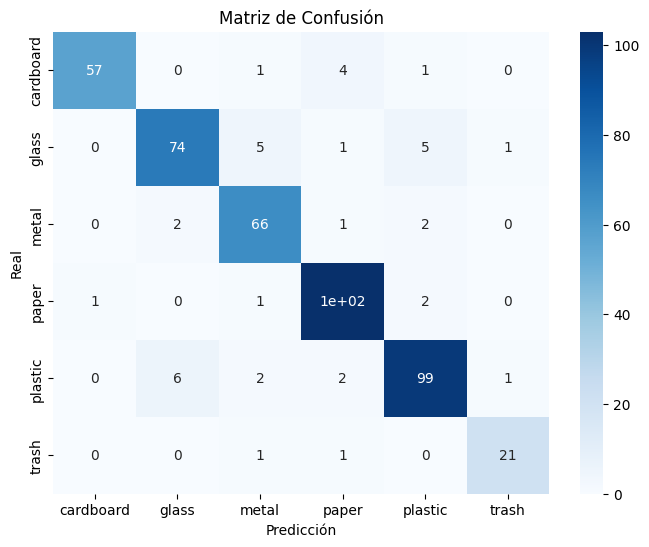

In [17]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(DEVICE)
        preds = model(xb).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("\n📊 Reporte de clasificación:\n")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))
# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


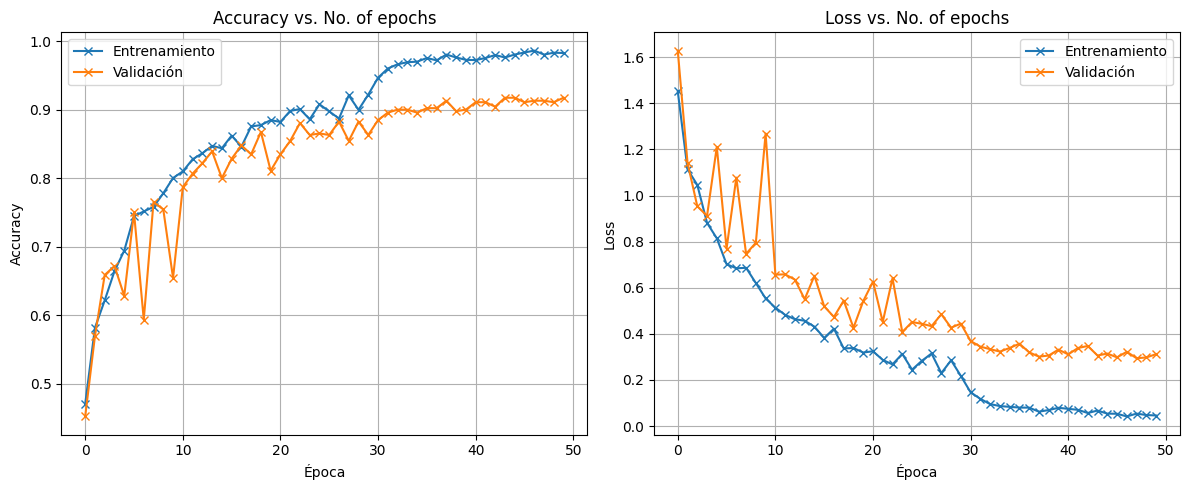

In [18]:
# === Gráficas de métricas por época ===
epochs_range = range(len(train_accuracies))

plt.figure(figsize=(12,5))

# --- Accuracy ---
plt.subplot(1,2,1)
plt.plot(epochs_range, train_accuracies, label='Entrenamiento', marker='x')
plt.plot(epochs_range, val_accuracies, label='Validación', marker='x')
plt.title('Accuracy vs. No. of epochs')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- Loss ---
plt.subplot(1,2,2)
plt.plot(epochs_range, train_losses, label='Entrenamiento', marker='x')
plt.plot(epochs_range, val_losses, label='Validación', marker='x')
plt.title('Loss vs. No. of epochs')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score
f1_macro = f1_score(all_labels, all_preds, average='macro')
print(f"\nF1 Macro Score: {f1_macro:.4f}")



F1 Macro Score: 0.9131


## Inferencia de Nuevas Imagenes

In [19]:
infer_model = models.resnet50(weights=None)
infer_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, num_classes)
)
infer_model.load_state_dict(
    torch.load("resnet50_trash_final_v3.pt", map_location=DEVICE)
)
infer_model = infer_model.to(DEVICE)
infer_model.eval()

infer_transforms = val_transforms

In [20]:
## función para predecir imagen individual
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    x = infer_transforms(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        probs = torch.softmax(infer_model(x), dim=1)[0]
        pred_idx = probs.argmax().item()

    print("\n🧠 Predicción:", full_dataset.classes[pred_idx])
    print("\nProbabilidades:")
    for cls, p in zip(full_dataset.classes, probs):
        print(f"{cls:10s}: {p.item()*100:.2f}%")

    plt.imshow(img)
    plt.title(full_dataset.classes[pred_idx])
    plt.axis("off")
    plt.show()

## Prediccion de imagenes


🧠 Predicción: plastic

Probabilidades:
cardboard : 0.00%
glass     : 38.51%
metal     : 0.00%
paper     : 0.00%
plastic   : 61.49%
trash     : 0.00%


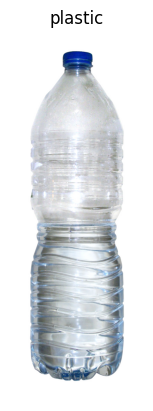

In [21]:
predict_image("test/test4.jpeg")


🧠 Predicción: plastic

Probabilidades:
cardboard : 0.00%
glass     : 0.15%
metal     : 0.00%
paper     : 0.00%
plastic   : 99.80%
trash     : 0.04%


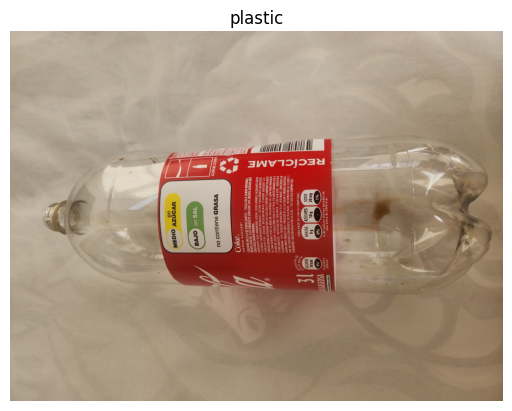

In [22]:
predict_image("test/test3.jpg")


🧠 Predicción: glass

Probabilidades:
cardboard : 0.00%
glass     : 99.98%
metal     : 0.01%
paper     : 0.00%
plastic   : 0.01%
trash     : 0.00%


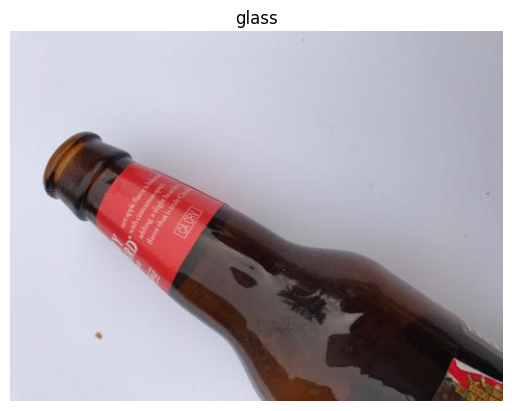

In [24]:
predict_image("test/test6.jpg")


🧠 Predicción: cardboard

Probabilidades:
cardboard : 54.51%
glass     : 0.00%
metal     : 0.00%
paper     : 45.48%
plastic   : 0.00%
trash     : 0.01%


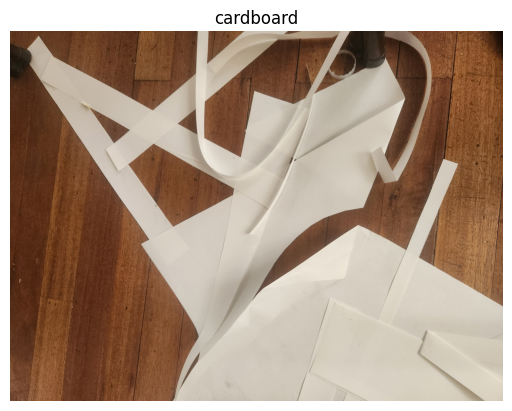

In [25]:
predict_image("test/test1.jpg")


🧠 Predicción: metal

Probabilidades:
cardboard : 0.00%
glass     : 0.21%
metal     : 99.76%
paper     : 0.00%
plastic   : 0.03%
trash     : 0.00%


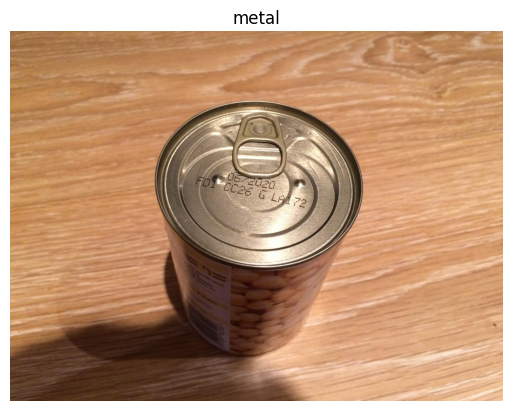

In [26]:
predict_image("test/test7.jpg")